In [1]:
import cv2 as cv
import pykitti
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basedir = '/Users/tarun/Classes/CS231A/project/KITTI/odometry/dataset'
sequence = '00'

dataset = pykitti.odometry(basedir, sequence)

P_left = dataset.calib.P_rect_00

P_right = dataset.calib.P_rect_10

In [18]:
print(dataset.calib.b_rgb)

print(dataset.calib.b_gray)

0.5323318472000029
0.5371657081270054


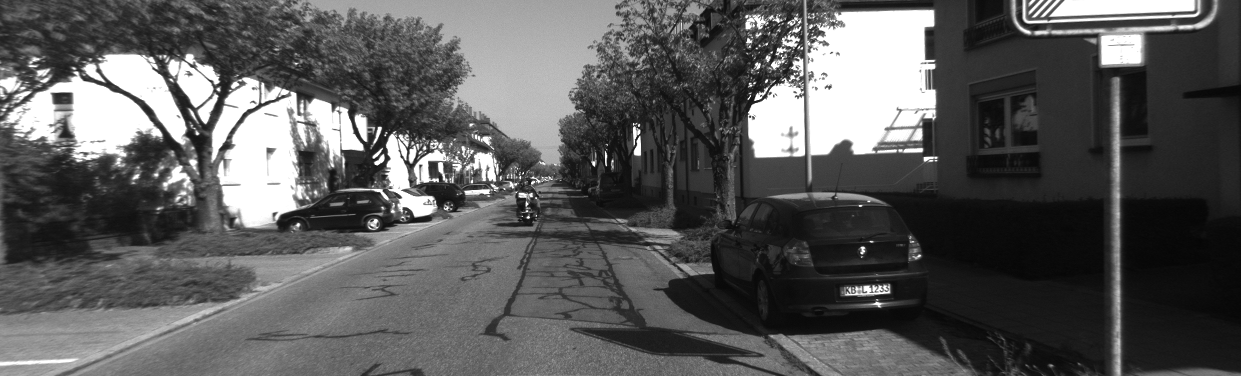

In [5]:
first_gray = next(iter(dataset.gray))

first_gray[1]

<AxesSubplot:>

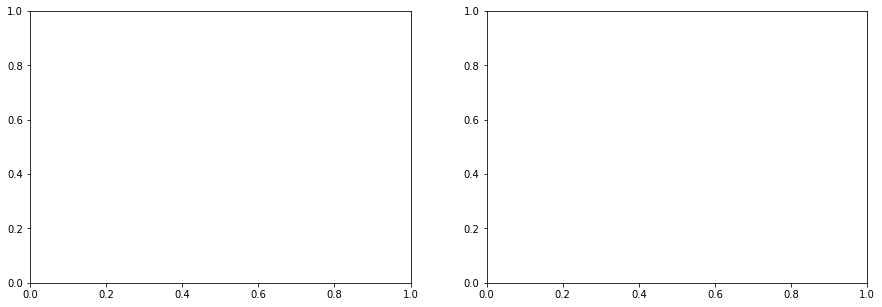

In [6]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0]

Text(0.5, 1.0, 'Gray Stereo Disparity')

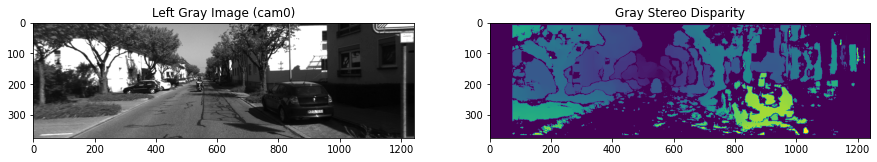

In [7]:
stereo = cv.StereoBM_create()

disp_gray = stereo.compute(np.array(first_gray[0]), np.array(first_gray[1]))

f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(first_gray[0], cmap='gray')
ax[0].set_title('Left Gray Image (cam0)')

ax[1].imshow(disp_gray, cmap='viridis')
ax[1].set_title('Gray Stereo Disparity')

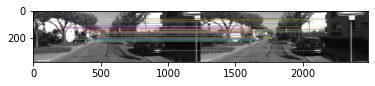

(<matplotlib.image.AxesImage at 0x134acc4c0>, None)

In [28]:
orb = cv.ORB_create()

img1 = np.array(first_gray[0])
img2 = np.array(first_gray[1])

kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 100 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:100],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3),plt.show()

In [19]:
len(kp1)

500

In [9]:
leftPoints = np.array([kp1[m.queryIdx].pt for m in matches]).T
rightPoints = np.array([kp2[m.trainIdx].pt for m in matches]).T

points = cv.triangulatePoints(P_left, P_right, leftPoints, rightPoints)

In [17]:
img1_2 = np.array(dataset.get_gray(1)[0])
img2_2 = np.array(dataset.get_gray(1)[1])

kp1_2, des1_2 = orb.detectAndCompute(img1_2,None)
kp2_2, des2_2 = orb.detectAndCompute(img2_2,None)

In [108]:
dataset.poses[2]

array([[ 9.999910e-01,  1.048972e-03, -4.131348e-03, -9.374345e-02],
       [-1.058514e-03,  9.999968e-01, -2.308104e-03, -5.676064e-02],
       [ 4.128913e-03,  2.312456e-03,  9.999887e-01,  1.716275e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [113]:
pose_itr = iter(dataset.poses)

next(pose_itr)

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11,  5.551115e-17],
       [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  3.330669e-16],
       [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -4.440892e-16],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [1]:
import sys
sys.path.insert(0, './disk')

from disk_feature import DiskFeature2D

disk_feature = DiskFeature2D()

Using DiskFeature2D
cuda: False
==> Loading pre-trained network.
==> Successfully loaded pre-trained network.


detector: DISK, descriptor: DISK, #features:  2000 , frame res:  (376, 1241)
detector: DISK, descriptor: DISK, #features:  2000 , frame res:  (376, 1241)


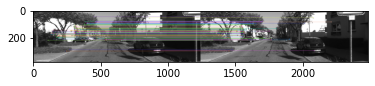

(<matplotlib.image.AxesImage at 0x13490ffa0>, None)

In [30]:
img1 = np.array(first_gray[0].convert("RGB"))
img2 = np.array(first_gray[1].convert("RGB"))

kp1, des1 = disk_feature.detectAndCompute(img1,None)
kp2, des2 = disk_feature.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 100 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:100],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3),plt.show()

In [29]:
print(des1.dtype)

print("min: ", np.min(des1), "max: ", np.max(des1))

uint8
min:  0 max:  255


In [10]:
import PIL.Image as pil

import sys
sys.path.insert(0, './monodepth2')
import torch
from torchvision import transforms

In [11]:
import networks
from utils import download_model_if_doesnt_exist

model_name = "mono+stereo_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

In [12]:
# image_path = "assets/test_image.jpg"

first_gray = next(iter(dataset.gray))[0]

input_image = first_gray.convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

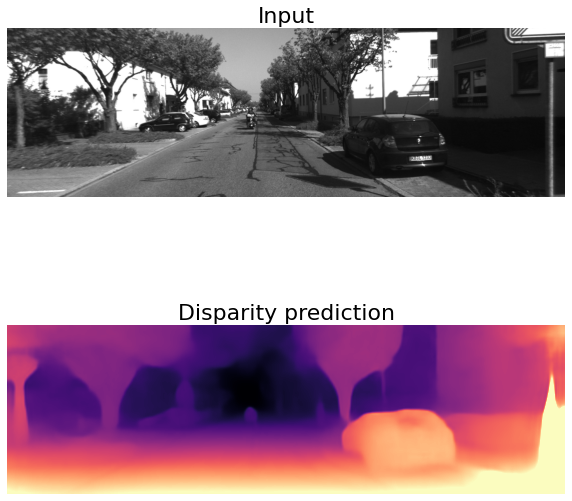

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [13]:
print(np.min(disp_resized_np))
print(np.max(disp_resized_np))

0.0014572367
0.13184194


In [14]:
from evaluate_depth import STEREO_SCALE_FACTOR
from layers import disp_to_depth
import skimage

scaled_disp, depth = disp_to_depth(disp, 0.1, 100)
metric_depth = STEREO_SCALE_FACTOR * depth

depth_resized = torch.nn.functional.interpolate(metric_depth,
    (original_height, original_width), mode="bilinear", align_corners=False)

depth_resized_np = depth_resized.squeeze().cpu().numpy()

In [15]:
print(np.min(depth_resized_np))
print(np.max(depth_resized_np))

4.0690227
219.88954


In [16]:
STEREO_SCALE_FACTOR

5.4